<a href="https://colab.research.google.com/github/andrewlee-29/Applied_Deep_Learning_2023Summer/blob/main/Week12_(DCGAN)_chapter12_part05_gans_MNIST_fromCondtGAN_student.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

## Introduction to generative adversarial networks

### A schematic GAN implementation

- A generator network maps vectors of shape (latent_dim,) to images of shape (64, 64, 3).
- A discriminator network maps images of shape (64, 64, 3) to a binary score estimating the probability that the image is real.
- A gan network chains the generator and the discriminator together: gan(x) = discriminator(generator(x)). Thus, this gan network maps latent space vectors to the discriminator’s assessment of the realism of these latent vectors as decoded by the generator.
- We train the discriminator using examples of real and fake images along with “real”/“fake” labels, just as we train any regular image-classification model.
- To train the generator, we use the gradients of the generator’s weights with regard to the loss of the gan model. This means that at every step, we move the weights of the generator in a direction that makes the discriminator more likely to classify as “real” the images decoded by the generator. In other words, we train the generator to fool the discriminator.

### A bag of tricks

### Getting our hands on the CelebA dataset

**Getting the CelebA data**

In [ ]:
!mkdir celeba_gan
!pip install gdown

In [ ]:
!gdown --id 1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684 -O celeba_gan/data.zip
!unzip -qq celeba_gan/data.zip -d celeba_gan

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684
To: /content/celeba_gan/data.zip
100% 1.44G/1.44G [00:29<00:00, 48.1MB/s]


**Creating a dataset from a directory of images**

Note: no labels—`label_mode=None`

In [ ]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=32,
    smart_resize=True)

Found 202599 files belonging to 1 classes.


**Rescaling the images**

In [ ]:
dataset = dataset.map(lambda x: x / 255.)
#0 to 1 scaling

**Displaying the first image**

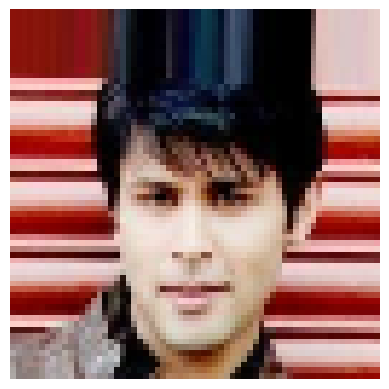

In [ ]:
import matplotlib.pyplot as plt
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

### The discriminator

> takes as input a candidate image (real or synthetic) and classifies it into one of two classes: “generated image” or “real image that comes from the training set.”

**The GAN discriminator network**

In [ ]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #32,32,64
        #vs ReLU helps avoid sparse gradients
        layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #16,16,128
        layers.Conv2D(128,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #8,8,128
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1,activation="sigmoid"),
    ],
    name="discriminator",
)

In [ ]:
discriminator.summary()

Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 128)         262272    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)            

### The generator

**GAN generator network**

> turns a vector (from the latent space—during training it will be sampled at random) into a candidate image.

In [ ]:
latent_dim = 128

#finished discriminator with:
# (Flatten)           (None, 8192)
#or (8, 8, 128)

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8*8*128),
        layers.Reshape((8,8,128)),
        layers.Conv2DTranspose(128,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #16,16,128
        layers.Conv2DTranspose(256,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #32,32,256
        layers.Conv2DTranspose(512,kernel_size=4,strides=2,padding="same"),
        layers.LeakyReLU(alpha=0.2), #64,64,512

        # output target 64,64,3
        layers.Conv2D(3,kernel_size=5,padding="same",activation='sigmoid')
    ],
    name="generator",
)

In [ ]:
generator.summary()

Model: "generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_2 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 16, 16, 128)      262272    
 ranspose)                                                       
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 16, 16, 128)       0         
                                                                 
 conv2d_transpose_4 (Conv2DT  (None, 32, 32, 256)      524544    
 ranspose)                                                       
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 32, 32, 256)       0 

### The adversarial network

**The GAN `Model`**

> For each epoch, you do the following:

- Draw random points in the latent space (random noise).
- Generate images with generator using this random noise.
- Mix the generated images with real ones.
- Train discriminator using these mixed images, with corresponding targets: either “real” (for the real images) or “fake” (for the generated images).
- Draw new random points in the latent space.
- Train generator using these random vectors, with targets that all say “these are real images.” This updates the weights of the generator to move them toward getting the discriminator to predict “these are real images” for generated images: this trains the generator to fool the discriminator.





In [ ]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        #setup 2 losses: Generator and Discriminator
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
      #1. grab random noise from latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))
        # 2. gen img
        generated_images = self.generator(random_latent_vectors)
        # 3. mix fake and real img
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))],
            axis=0
        )
        #add random noise to labels; helps if stuck!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))


        # 4. Train the Discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

      #5. grab more random noise from latent space
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim))

        misleading_labels = tf.zeros((batch_size, 1))

        # 6. Train the Generator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(
                self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights))

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {"d_loss": self.d_loss_metric.result(),
                "g_loss": self.g_loss_metric.result()}

**A callback that samples generated images during training**

> a callback to monitor our results: it will use the generator to create and save a number of fake images at the end of each epoch.

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

**Compiling and training the GAN**

In [ ]:
epochs = 100

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/100


2022-03-26 15:38:07.653887: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


6332/6332 [==============================] - 3270s 516ms/step - d_loss: 0.6191 - g_loss: 1.2206
Epoch 2/100
6332/6332 [==============================] - 3206s 506ms/step - d_loss: 0.6593 - g_loss: 1.0582
Epoch 3/100
6332/6332 [==============================] - 3172s 501ms/step - d_loss: 0.6511 - g_loss: 1.0977
Epoch 4/100
6332/6332 [==============================] - 3227s 510ms/step - d_loss: 0.6637 - g_loss: 1.0633
Epoch 5/100
6332/6332 [==============================] - 3168s 500ms/step - d_loss: 0.6551 - g_loss: 1.0595
Epoch 6/100
6332/6332 [==============================] - 3198s 505ms/step - d_loss: 0.6644 - g_loss: 0.9732
Epoch 7/100
6332/6332 [==============================] - 3159s 499ms/step - d_loss: 0.6687 - g_loss: 0.9636
Epoch 8/100
6332/6332 [==============================] - 3146s 497ms/step - d_loss: 0.6788 - g_loss: 0.9095
Epoch 9/100
6332/6332 [==============================] - 3148s 497ms/step - d_loss: 0.6819 - g_loss: 0.8933
Epoch 10/100
6332/6332 [================

### Wrapping up

## Summary